## World Development Indicators - Analytics

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import Imputer
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer

datos = pd.read_csv("suramerica.csv").drop('Unnamed: 0', 1)
datos.head()

C:\Program Files\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Program Files\Anaconda2\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


,CountryName,CountryCode,IndicatorName,IndicatorCode,Year,Value
0,Antigua and Barbuda,ATG,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,1960,126.144000
1,Antigua and Barbuda,ATG,Age dependency ratio (% of working-age populat...,SP.POP.DPND,1960,88.237117
2,Antigua and Barbuda,ATG,"Age dependency ratio, old (% of working-age po...",SP.POP.DPND.OL,1960,7.779958
3,Antigua and Barbuda,ATG,"Age dependency ratio, young (% of working-age ...",SP.POP.DPND.YG,1960,80.457159
4,Antigua and Barbuda,ATG,"Birth rate, crude (per 1,000 people)",SP.DYN.CBRT.IN,1960,32.920000


In [2]:
def r2(y_true, y_predict):
    return r2_score(y_true, y_predict)

In [3]:
def imputador(tab):
    impute=Imputer(missing_values="NaN",strategy='mean',axis=0)
    impute.fit(tab)
    tab_imputada=impute.transform(tab)
    return pd.DataFrame(tab_imputada)

In [4]:
def zeros(tab):
    #Asignamos a los NaN el valor de 0
    tab_zeros = pd.DataFrame(tab).fillna(value=0)
    #Eliminamos las columnas de Zeros descartando Indicadores que no tienen regristros para ningún pais y año deseados
    tab_zeros_2 = tab_zeros.loc[:, (tab_zeros != 0).any(axis=0)]
    return tab_zeros_2

In [5]:
def Grid_Search_CV(X_train, y_train):
    cv = ShuffleSplit(X_train.shape[0], n_iter = 10, test_size=0.2, random_state=0)
    estimator = DecisionTreeRegressor()
    params = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'splitter': ['best', 'random']}

    grid = GridSearchCV(estimator, params, cv=cv, scoring="r2")

    grid.fit(X_train, y_train)
    
    for k,v in grid.best_params_.iteritems():
        best_max_depth = v
    
    return best_max_depth

In [6]:
def DTR_v2(X_train, X_test, y_train, y_test, depth):
    estimator = DecisionTreeRegressor(max_depth=depth)
    estimator.fit(X_train,y_train)
    y_predict = estimator.predict(X_test)
    return r2(y_test,y_predict)

In [7]:
def correlation_matrix(df):
    from matplotlib import pyplot as plt
    from matplotlib import cm as cm

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
    plt.title('Matriz de correlacion')
    fig.colorbar(cax)
    plt.show()

In [8]:
def correlacion(tab,y_indicator):
    # Buscamos los indicadores que se correlacionen más (coeficiente > 0.7)
    eliminar = []
    tabla_correlacion = np.array(pd.DataFrame(tab).corr())
    for i in range(np.shape(tab)[1]):
        if abs(tabla_correlacion[i,y_indicator]) > 0.7:
            eliminar.append(i)

    # Eliminamos los indicadores que se correlacionan más (Coeficiente > 0.7)
    temporal = tab[:,:]

    for i in range(len(eliminar)):
        temporal = np.delete(temporal[:,:], eliminar[i]-i, 1)

    return temporal

In [9]:
def splitter_v2(tab,y_indicator):
    # Asignamos X e y, eliminando los indicadores que se correlacionen más (coeficiente > 0.7)
    X = correlacion(tab,y_indicator)
    y = tab[:,y_indicator]
    
    # Separamos Train y Test respectivamente para X e y
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    return X_train, X_test, y_train, y_test

In [10]:
def splitter_v3(tabla_1,tabla_2,y_indicator):
    #Fusionamos la tabla_1 y el indicador y de la tabla_2
    tab_fusion = np.column_stack((tabla_1[:,:],tabla_2[:,y_indicator]))
    
    # Asignamos X e y, eliminando los indicadores que se correlacionen más (coeficiente > 0.7)  
    X = correlacion(tab_fusion,-1)
    y = tab_fusion[:,-1]
    
    # Separamos Train y Test respectivamente para X e y
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    return X_train, X_test, y_train, y_test

In [11]:
def iter_R2_Splitter_v2(tab):
    R2_global = list()

    for i in range(0,np.shape(tab)[1]):
        ## Zeros
        X_train, X_test, y_train, y_test = splitter_v2(np.array(zeros(tab)),i)
        best_max_depth = Grid_Search_CV(X_train, y_train)
        R2_Original_GridSearchCV = DTR_v2(X_train, X_test, y_train, y_test,best_max_depth)

        ## Imputado
        X_train, X_test, y_train, y_test = splitter_v2(np.array(imputador(tab)),i)
        best_max_depth = Grid_Search_CV(X_train, y_train)
        R2_Imputado_GridSearchCV = DTR_v2(X_train, X_test, y_train, y_test,best_max_depth)

        # Recopilamos los R2
        R2_global.append([R2_Original_GridSearchCV,R2_Imputado_GridSearchCV])

    return pd.DataFrame(R2_global,columns=['Original','Imputado'])

In [12]:
def iter_R2_Splitter_v3(tab1,tab2):    
    R2_global = list()
    for i in range(0,np.shape(tab2)[1]):
        ## Zeros
        X_train, X_test, y_train, y_test = splitter_v3(np.array(zeros(tab1)),np.array(zeros(tab2)),i)
        best_max_depth = Grid_Search_CV(X_train, y_train)
        R2_Original_GridSearchCV = DTR_v2(X_train, X_test, y_train, y_test,best_max_depth)

        ## Imputado
        X_train, X_test, y_train, y_test = splitter_v3(np.array(imputador(tab1)),np.array(imputador(tab2)),i)
        best_max_depth = Grid_Search_CV(X_train, y_train)
        R2_Imputado_GridSearchCV = DTR_v2(X_train, X_test, y_train, y_test,best_max_depth)

        # Recopilamos los R2
        R2_global.append([R2_Original_GridSearchCV,R2_Imputado_GridSearchCV])
    
    return pd.DataFrame(R2_global,columns=['Original','Imputado'])

In [13]:
def porcentaje(valor):
    x=0.0
    for i in np.array(valor):
        if (i[0] > 0.9 and i[1] > 0.9):
            x=x+1
    return x/len(valor)

In [14]:
def tabla_base(paises,years,indicadores,datos):
    tab = pd.DataFrame.pivot_table(datos, values='Value', index=['CountryName', 'Year'], columns=['IndicatorCode']).loc[(paises,years[::-1]),indicadores]
    return tab

In [15]:
def iterador_global(datos,paises,years,indicadores_1,indicadores_2):
    
    t_1 = tabla_base(paises,years,indicadores_1,datos)
    t_2 = tabla_base(paises,years,indicadores_2,datos)
    
    iterador = iter_R2_Splitter_v3(t_1,t_2)
    
    return iterador

In [26]:
def iterador_global_2(datos,paises,years,indicadores_1,indicadores_2):
    
    t_1 = tabla_2_base(datos,indicadores_1,look_back)
    t_2 = tabla_2_base(datos,indicadores_2,look_back)
    
    iterador = iter_R2_Splitter_v3(t_1,t_2)
    
    return iterador

In [16]:
paises = ['Antigua and Barbuda','Argentina','Aruba','Bahamas, The','Barbados','Belize','Bolivia','Brazil','Cayman Islands','Chile','Colombia','Costa Rica','Cuba','Curacao','Dominica','Dominican Republic','Ecuador','El Salvador','Grenada','Guatemala','Guyana','Haiti','Honduras','Jamaica','Mexico','Nicaragua','Panama','Paraguay','Peru','Puerto Rico','Sint Maarten (Dutch part)','St. Kitts and Nevis','St. Lucia','St. Martin (French part)','St. Vincent and the Grenadines','Suriname','Trinidad and Tobago','Turks and Caicos Islands','Uruguay','Venezuela, RB','Virgin Islands (U.S.)']
years = range(2008,2012+1)
gdp = ['NY.GDP.MKTP.KN','NY.GDP.MKTP.CN','NY.GDP.MKTP.CD']
gross = ['NE.GDI.TOTL.ZS','NE.GDI.TOTL.KD.ZG','NE.GDI.TOTL.KD','NE.GDI.TOTL.KN','NE.GDI.TOTL.CN','NE.GDI.TOTL.CD','NY.GDY.TOTL.KN','NY.GDS.TOTL.ZS','NY.GDS.TOTL.CN','NY.GDS.TOTL.CD','NE.GDI.FTOT.ZS','NE.GDI.FTOT.KD.ZG','NE.GDI.FTOT.KD','NE.GDI.FTOT.KN','NE.GDI.FTOT.CN','NE.GDI.FTOT.CD','NE.GDI.FPRV.ZS','NE.GDI.FPRV.CN','NE.DAB.TOTL.ZS','NE.DAB.TOTL.KD','NE.DAB.TOTL.KN','NE.DAB.TOTL.CN','NE.DAB.TOTL.CD','NE.DAB.DEFL.ZS','NY.GNS.ICTR.ZS','NY.GNS.ICTR.GN.ZS','NY.GNS.ICTR.CN','NY.GNS.ICTR.CD','NY.GDP.FCST.KD','NY.GDP.FCST.KN','NY.GDP.FCST.CN','NY.GDP.FCST.CD']
gni = ['NY.GNP.MKTP.KD','NY.GNP.MKTP.KN','NY.GNP.MKTP.CN','NY.GNP.MKTP.CD','NY.GNP.MKTP.KD.ZG','NY.GNP.PCAP.KD','NY.GNP.PCAP.KN','NY.GNP.PCAP.CN','NY.GNP.PCAP.KD.ZG','NY.GNP.PCAP.CD','NY.GNP.PCAP.PP.KD','NY.GNP.PCAP.PP.CD','NY.GNP.ATLS.CD','NY.GNP.MKTP.PP.KD','NY.GNP.MKTP.PP.CD']
conjunto_nombre = ['GDP','Gross','GNI']
conjunto = [gdp,gross,gni]

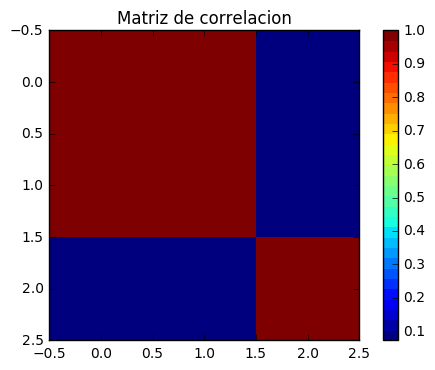

In [38]:
correlation_matrix(tabla_base(paises,years,gdp,datos))

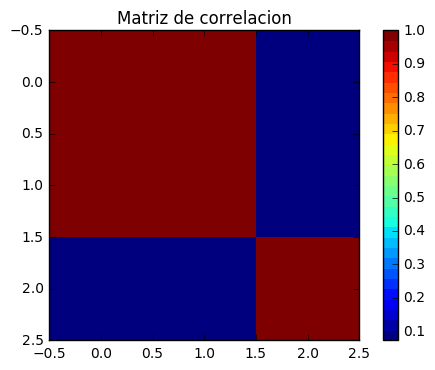

In [36]:
correlation_matrix(tabla_2_base(datos,gdp,1))

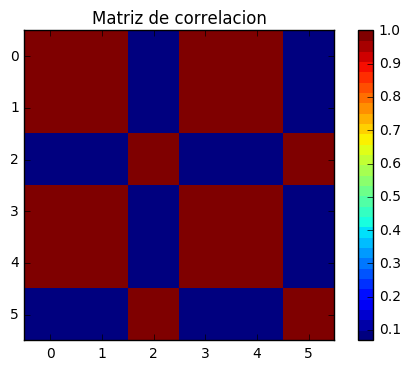

In [35]:
correlation_matrix(tabla_2_base(datos,gdp,2))

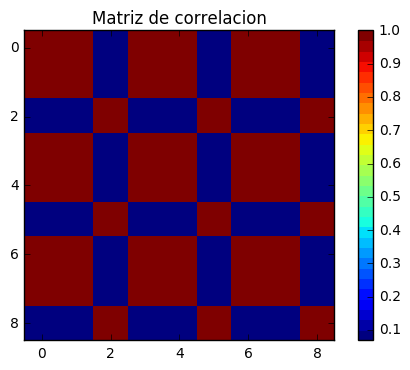

In [37]:
correlation_matrix(tabla_2_base(datos,gdp,3))

In [23]:
for k in range(3):
    temp_years = []
    for i in range(len(years)): 
        temp_years.append(years[i]-k)
temp_years

[2008, 2009, 2010, 2011, 2012]
[2007, 2008, 2009, 2010, 2011]
[2006, 2007, 2008, 2009, 2010]


[2006, 2007, 2008, 2009, 2010]

In [42]:
t1 = pd.DataFrame.pivot_table(datos, values='Value', index=['CountryName', 'Year'], columns=['IndicatorCode']).loc[(paises,years),gdp].sortlevel(["CountryName","Year"], ascending=[True,False])
t1

IndicatorCode                  NY.GDP.MKTP.KN  NY.GDP.MKTP.CN  NY.GDP.MKTP.CD
CountryName              Year                                                
Antigua and Barbuda      2012    2.802259e+09    3.252725e+09    1.204713e+09
                         2011    2.693974e+09    3.050780e+09    1.129918e+09
                         2010    2.743171e+09    3.065955e+09    1.135539e+09
                         2009    2.954188e+09    3.257308e+09    1.206410e+09
                         2008    3.358406e+09    3.637845e+09    1.347350e+09
Argentina                2012    8.445081e+11    2.765575e+12    6.043785e+11
                         2011    8.377910e+11    2.312009e+12    5.578902e+11
                         2010    7.729666e+11    1.810830e+12    4.616402e+11
                         2009    7.062178e+11    1.411526e+12    3.766279e+11
                         2008    7.058647e+11    1.283906e+12    4.037820e+11
Aruba                    2012             NaN             NaN             NaN
                         2011             NaN    4.626190e+09    2.584464e+09
                         2010             NaN    4.417190e+09    2.467704e+09
                         2009    3.107000e+09    4.473090e+09    2.498933e+09
                         2008    3.293180e+09    4.997610e+09    2.791961e+09
Bahamas, The             2012    7.898250e+09    8.234470e+09    8.234470e+09
                         2011    7.726920e+09    7.889750e+09    7.889750e+09
                         2010    7.679850e+09    7.909580e+09    7.909580e+09
                         2009    7.563465e+09    7.820420e+09    7.820420e+09
                         2008    7.893019e+09    8.246650e+09    8.246650e+09
Barbados                 2012    1.109000e+09    8.626000e+09    4.313000e+09
                         2011    1.106000e+09    8.716000e+09    4.358000e+09
                         2010    1.098000e+09    8.891000e+09    4.445500e+09
                         2009    1.095000e+09    9.204000e+09    4.602000e+09
                         2008    1.141000e+09    9.190000e+09    4.595000e+09
Belize                   2012    2.596031e+09    3.147735e+09    1.573867e+09
                         2011    2.500397e+09    2.974011e+09    1.487006e+09
                         2010    2.448874e+09    2.794227e+09    1.397113e+09
                         2009    2.370095e+09    2.673914e+09    1.336957e+09
                         2008    2.353310e+09    2.737250e+09    1.368625e+09
...                                       ...             ...             ...
Suriname                 2012    9.867000e+09    1.643400e+10    4.980000e+09
                         2011    9.573000e+09    1.445200e+10    4.422277e+09
                         2010    9.094000e+09    1.199300e+10    4.368398e+09
                         2009    8.648000e+09    1.063800e+10    3.875410e+09
                         2008    8.395000e+09    9.698000e+09    3.532969e+09
Trinidad and Tobago      2012    8.997800e+10    1.580450e+11    2.458084e+10
                         2011    8.876500e+10    1.564500e+11    2.440984e+10
                         2010    8.875900e+10    1.341250e+11    2.103757e+10
                         2009    8.884200e+10    1.212810e+11    1.917516e+10
                         2008    9.292100e+10    1.752870e+11    2.787023e+10
Turks and Caicos Islands 2012             NaN             NaN             NaN
                         2011             NaN             NaN             NaN
                         2010             NaN             NaN             NaN
                         2009             NaN             NaN             NaN
                         2008             NaN             NaN             NaN
Uruguay                  2012    6.168902e+11    1.043637e+12    5.138487e+10
                         2011    5.970496e+11    9.263561e+11    4.796244e+10
                         2010    5.677420e+11    8.080785e+11    4.028468e+10
                      

In [43]:
t2 = pd.DataFrame.pivot_table(datos, values='Value', index=['CountryName', 'Year'], columns=['IndicatorCode']).loc[(paises,years2),gdp].sortlevel(["CountryName","Year"], ascending=[True,False])
t2

IndicatorCode                  NY.GDP.MKTP.KN  NY.GDP.MKTP.CN  NY.GDP.MKTP.CD
CountryName              Year                                                
Antigua and Barbuda      2011    2.693974e+09    3.050780e+09    1.129918e+09
                         2010    2.743171e+09    3.065955e+09    1.135539e+09
                         2009    2.954188e+09    3.257308e+09    1.206410e+09
                         2008    3.358406e+09    3.637845e+09    1.347350e+09
                         2007    3.356020e+09    3.480987e+09    1.289254e+09
Argentina                2011    8.377910e+11    2.312009e+12    5.578902e+11
                         2010    7.729666e+11    1.810830e+12    4.616402e+11
                         2009    7.062178e+11    1.411526e+12    3.766279e+11
                         2008    7.058647e+11    1.283906e+12    4.037820e+11
                         2007    6.848073e+11    1.027339e+12    3.293175e+11
Aruba                    2011             NaN    4.626190e+09    2.584464e+09
                         2010             NaN    4.417190e+09    2.467704e+09
                         2009    3.107000e+09    4.473090e+09    2.498933e+09
                         2008    3.293180e+09    4.997610e+09    2.791961e+09
                         2007    3.536540e+09    4.696470e+09    2.623726e+09
Bahamas, The             2011    7.726920e+09    7.889750e+09    7.889750e+09
                         2010    7.679850e+09    7.909580e+09    7.909580e+09
                         2009    7.563465e+09    7.820420e+09    7.820420e+09
                         2008    7.893019e+09    8.246650e+09    8.246650e+09
                         2007    8.080812e+09    8.318996e+09    8.318996e+09
Barbados                 2011    1.106000e+09    8.716000e+09    4.358000e+09
                         2010    1.098000e+09    8.891000e+09    4.445500e+09
                         2009    1.095000e+09    9.204000e+09    4.602000e+09
                         2008    1.141000e+09    9.190000e+09    4.595000e+09
                         2007    1.136000e+09    9.092000e+09    4.546000e+09
Belize                   2011    2.500397e+09    2.974011e+09    1.487006e+09
                         2010    2.448874e+09    2.794227e+09    1.397113e+09
                         2009    2.370095e+09    2.673914e+09    1.336957e+09
                         2008    2.353310e+09    2.737250e+09    1.368625e+09
                         2007    2.279696e+09    2.581085e+09    1.290543e+09
...                                       ...             ...             ...
Suriname                 2011    9.573000e+09    1.445200e+10    4.422277e+09
                         2010    9.094000e+09    1.199300e+10    4.368398e+09
                         2009    8.648000e+09    1.063800e+10    3.875410e+09
                         2008    8.395000e+09    9.698000e+09    3.532969e+09
                         2007    8.061000e+09    8.061000e+09    2.936612e+09
Trinidad and Tobago      2011    8.876500e+10    1.564500e+11    2.440984e+10
                         2010    8.875900e+10    1.341250e+11    2.103757e+10
                         2009    8.884200e+10    1.212810e+11    1.917516e+10
                         2008    9.292100e+10    1.752870e+11    2.787023e+10
                         2007    8.987400e+10    1.369530e+11    2.164238e+10
Turks and Caicos Islands 2011             NaN             NaN             NaN
                         2010             NaN             NaN             NaN
                         2009             NaN             NaN             NaN
                         2008             NaN             NaN             NaN
                         2007             NaN             NaN             NaN
Uruguay                  2011    5.970496e+11    9.263561e+11    4.796244e+10
                         2010    5.677420e+11    8.080785e+11    4.028468e+10
                         2009    5.266457e+11    7.145234e+11    3.166091e+10
                      

In [44]:
t3 = pd.DataFrame.pivot_table(datos, values='Value', index=['CountryName', 'Year'], columns=['IndicatorCode']).loc[(paises,temp_years),gdp].sortlevel(["CountryName","Year"], ascending=[True,False])
t3

IndicatorCode                  NY.GDP.MKTP.KN  NY.GDP.MKTP.CN  NY.GDP.MKTP.CD
CountryName              Year                                                
Antigua and Barbuda      2010    2.743171e+09    3.065955e+09    1.135539e+09
                         2009    2.954188e+09    3.257308e+09    1.206410e+09
                         2008    3.358406e+09    3.637845e+09    1.347350e+09
                         2007    3.356020e+09    3.480987e+09    1.289254e+09
                         2006    3.064888e+09    3.064888e+09    1.135144e+09
Argentina                2010    7.729666e+11    1.810830e+12    4.616402e+11
                         2009    7.062178e+11    1.411526e+12    3.766279e+11
                         2008    7.058647e+11    1.283906e+12    4.037820e+11
                         2007    6.848073e+11    1.027339e+12    3.293175e+11
                         2006    6.342830e+11    8.085926e+11    2.626665e+11
Aruba                    2010             NaN    4.417190e+09    2.467704e+09
                         2009    3.107000e+09    4.473090e+09    2.498933e+09
                         2008    3.293180e+09    4.997610e+09    2.791961e+09
                         2007    3.536540e+09    4.696470e+09    2.623726e+09
                         2006    3.670690e+09    4.334440e+09    2.421475e+09
Bahamas, The             2010    7.679850e+09    7.909580e+09    7.909580e+09
                         2009    7.563465e+09    7.820420e+09    7.820420e+09
                         2008    7.893019e+09    8.246650e+09    8.246650e+09
                         2007    8.080812e+09    8.318996e+09    8.318996e+09
                         2006    7.965588e+09    7.965588e+09    7.965588e+09
Barbados                 2010    1.098000e+09    8.891000e+09    4.445500e+09
                         2009    1.095000e+09    9.204000e+09    4.602000e+09
                         2008    1.141000e+09    9.190000e+09    4.595000e+09
                         2007    1.136000e+09    9.092000e+09    4.546000e+09
                         2006    1.117000e+09    8.607000e+09    4.303500e+09
Belize                   2010    2.448874e+09    2.794227e+09    1.397113e+09
                         2009    2.370095e+09    2.673914e+09    1.336957e+09
                         2008    2.353310e+09    2.737250e+09    1.368625e+09
                         2007    2.279696e+09    2.581085e+09    1.290543e+09
                         2006    2.254768e+09    2.434884e+09    1.217442e+09
...                                       ...             ...             ...
Suriname                 2010    9.094000e+09    1.199300e+10    4.368398e+09
                         2009    8.648000e+09    1.063800e+10    3.875410e+09
                         2008    8.395000e+09    9.698000e+09    3.532969e+09
                         2007    8.061000e+09    8.061000e+09    2.936612e+09
                         2006    7.669000e+09    7.206000e+09    2.626380e+09
Trinidad and Tobago      2010    8.875900e+10    1.341250e+11    2.103757e+10
                         2009    8.884200e+10    1.212810e+11    1.917516e+10
                         2008    9.292100e+10    1.752870e+11    2.787023e+10
                         2007    8.987400e+10    1.369530e+11    2.164238e+10
                         2006    8.579500e+10    1.159510e+11    1.836906e+10
Turks and Caicos Islands 2010             NaN             NaN             NaN
                         2009             NaN             NaN             NaN
                         2008             NaN             NaN             NaN
                         2007             NaN             NaN             NaN
                         2006             NaN             NaN             NaN
Uruguay                  2010    5.677420e+11    8.080785e+11    4.028468e+10
                         2009    5.266457e+11    7.145234e+11    3.166091e+10
                         2008    5.052072e+11    6.361509e+11    3.036621e+10
                      

In [45]:
pd.DataFrame(np.column_stack([t1,t2]))

,0,1,2,3,4,5
0,2.802259e+09,3.252725e+09,1.204713e+09,2.693974e+09,3.050780e+09,1.129918e+09
1,2.693974e+09,3.050780e+09,1.129918e+09,2.743171e+09,3.065955e+09,1.135539e+09
2,2.743171e+09,3.065955e+09,1.135539e+09,2.954188e+09,3.257308e+09,1.206410e+09
3,2.954188e+09,3.257308e+09,1.206410e+09,3.358406e+09,3.637845e+09,1.347350e+09
4,3.358406e+09,3.637845e+09,1.347350e+09,3.356020e+09,3.480987e+09,1.289254e+09
5,8.445081e+11,2.765575e+12,6.043785e+11,8.377910e+11,2.312009e+12,5.578902e+11
6,8.377910e+11,2.312009e+12,5.578902e+11,7.729666e+11,1.810830e+12,4.616402e+11
7,7.729666e+11,1.810830e+12,4.616402e+11,7.062178e+11,1.411526e+12,3.766279e+11
8,7.062178e+11,1.411526e+12,3.766279e+11,7.058647e+11,1.283906e+12,4.037820e+11
9,7.058647e+11,1.283906e+12,4.037820e+11,6.848073e+11,1.027339e+12,3.293175e+11


In [31]:
tabla_2_base(datos,gdp,2).head()

,0,1,2,3,4,5
0,2.802259e+09,3.252725e+09,1.204713e+09,2.693974e+09,3.050780e+09,1.129918e+09
1,2.693974e+09,3.050780e+09,1.129918e+09,2.743171e+09,3.065955e+09,1.135539e+09
2,2.743171e+09,3.065955e+09,1.135539e+09,2.954188e+09,3.257308e+09,1.206410e+09
3,2.954188e+09,3.257308e+09,1.206410e+09,3.358406e+09,3.637845e+09,1.347350e+09
4,3.358406e+09,3.637845e+09,1.347350e+09,3.356020e+09,3.480987e+09,1.289254e+09


In [34]:
tabla_2_base(datos,gdp,3).head()

,0,1,2,3,4,5,6,7,8
0,2.802259e+09,3.252725e+09,1.204713e+09,2.693974e+09,3.050780e+09,1.129918e+09,2.743171e+09,3.065955e+09,1.135539e+09
1,2.693974e+09,3.050780e+09,1.129918e+09,2.743171e+09,3.065955e+09,1.135539e+09,2.954188e+09,3.257308e+09,1.206410e+09
2,2.743171e+09,3.065955e+09,1.135539e+09,2.954188e+09,3.257308e+09,1.206410e+09,3.358406e+09,3.637845e+09,1.347350e+09
3,2.954188e+09,3.257308e+09,1.206410e+09,3.358406e+09,3.637845e+09,1.347350e+09,3.356020e+09,3.480987e+09,1.289254e+09
4,3.358406e+09,3.637845e+09,1.347350e+09,3.356020e+09,3.480987e+09,1.289254e+09,3.064888e+09,3.064888e+09,1.135144e+09


In [29]:
def tabla_2_base(datos,indicadores,look_back):
    temp_table = []
    for k in range(look_back):
        temp_years = []
        for i in range(len(years)): 
            temp_years.append(years[i]-k)
        temp_table.append(pd.DataFrame.pivot_table(datos, values='Value', index=['CountryName', 'Year'], columns=['IndicatorCode']).loc[(paises,temp_years),indicadores].sortlevel(["CountryName","Year"], ascending=[True,False]))
    return pd.DataFrame(np.column_stack(temp_table))

In [46]:
look_back = 2
temp_years = []
for k in range(look_back):
    for i in range(len(years)): 
        temp_years.append(years[i]-k)
temp_years

[2008, 2009, 2010, 2011, 2012, 2007, 2008, 2009, 2010, 2011]

In [17]:
start_time = time.time()

resultado = []
for i in range(len(conjunto)):
    resultado.append([conjunto_nombre[0],conjunto_nombre[i],porcentaje(iterador_global(datos,paises,years,conjunto[0],conjunto[i]))])
    
print("--- %s seconds ---" % (time.time() - start_time))
pd.DataFrame(resultado, columns=["Base","Target","% > 90%"])

--- 99.3480000496 seconds ---


,Base,Target,% > 90%
0,GDP,GDP,0.466667
1,GDP,Gross,0.500000
2,GDP,GNI,0.266667


In [18]:
import plotly.plotly as py
import plotly.graph_objs as go

data = [go.Bar(
            x=['GDP', 'Gross', 'GNI'],
            y=np.array(resultado)[:,2]
    )]

py.iplot(data, filename='GDP')

In [19]:
start_time = time.time()

resultado = []
for i in range(len(conjunto)):
    for j in range(len(conjunto)):
        resultado.append([conjunto_nombre[i],conjunto_nombre[j],porcentaje(iterador_global(datos,paises,years,conjunto[i],conjunto[j]))])
        
print("--- %s seconds ---" % (time.time() - start_time))
pd.DataFrame(resultado, columns=["Base","Target","% > 90%"])

--- 301.758999825 seconds ---


,Base,Target,% > 90%
0,GDP,GDP,0.066667
1,GDP,Gross,0.187500
2,GDP,GNI,0.266667
3,Gross,GDP,0.200000
4,Gross,Gross,0.218750
5,Gross,GNI,0.266667
6,GNI,GDP,0.400000
7,GNI,Gross,0.375000
8,GNI,GNI,0.333333


In [20]:
import plotly.plotly as py
import plotly.graph_objs as go

trace0 = go.Bar(
    x=conjunto_nombre,
    y=[np.array(resultado)[0,2],np.array(resultado)[3,2],np.array(resultado)[6,2]],
    name='GDP')

trace1 = go.Bar(
    x=conjunto_nombre,
    y=[np.array(resultado)[1,2],np.array(resultado)[4,2],np.array(resultado)[7,2]],
    name='Gross')

trace2 = go.Bar(
    x=conjunto_nombre,
    y=[np.array(resultado)[2,2],np.array(resultado)[5,2],np.array(resultado)[8,2]],
    name='GNI')

data = [trace0, trace1, trace2]
layout = go.Layout(barmode='group')

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Resultado 2')

In [21]:
data = [
        go.Heatmap(
            z=np.array(resultado)[:,2],
            x=np.array(resultado)[:,1],
            y=np.array(resultado)[:,0],
            colorscale='Viridis'
        )
    ]
py.iplot(data, filename='Resultado Global')